In [17]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

%matplotlib inline
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['mathtext.fontset'] = 'stix'

# #Fock State

\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}

where $\gamma_n = \gamma_0(n+1)^{0.7}$ is the decoherence rate between levels $|n\rangle$ and $|n+1\rangle$

\begin{equation}
\Omega_{n,n+1} = \Omega_0\sqrt{n+1}\eta
\end{equation}
when $\eta\ll 1$
Here we use JCM to generate the data and use the formula above to fit it.
\begin{equation}
    H = \hbar \nu \hat{a}^\dagger \hat{a} + \frac{1}{2}\hbar\omega_0\sigma_z + \hbar\Omega(\sigma_+e^{i\eta(a+a^\dagger)}+h.c.)
\end{equation}
But in real:
\begin{equation}
\Omega_{n,n+s} = \Omega_{n+s,n} = \Omega_{0} e^{-\eta^2/2}\eta^{|s|}\sqrt{\frac{n_<!}{n_>!}}L^{|s|}_{n_<}(\eta^2)
\end{equation}
where $n_<$ ($n_>$ ) is the lesser (greater) of n+s and n
If s=1:
\begin{equation}
\Omega_{n,n+1} = \Omega_{n+1,n} = \Omega_{0} e^{-\eta^2/2}\eta L_{n}(\eta^2)/\sqrt{n+1}
\end{equation}

And:
\begin{equation}
    L_n^\alpha(X) = \sum_{m=0}^n(-1)^mC_{n+\alpha}^{n-m}\frac{X^m}{m!}
\end{equation}
Thus $\Omega_{n+1,n}/\Omega_{0,1} = L^1_{n}(\eta^2)/\sqrt{n+1}$

In [18]:
from scipy.special import genlaguerre

Text(0, 0.5, '$\\Omega_{n,n+1}/\\Omega_{0,1}$')

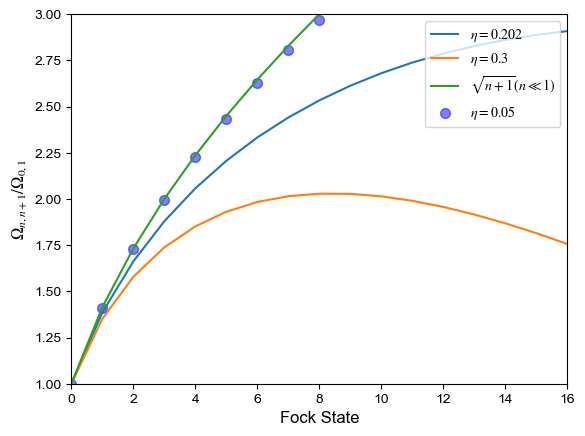

In [19]:
Fock_state = np.array(range(0,20))
def genlaguerre_function(eta,nlist,s):
    function_value = []
    for n in nlist:
        function_value.append(genlaguerre(n,s)(eta**2))
    return np.array(function_value)
function_value01 = genlaguerre_function(0.202,Fock_state,1)
function_value02 = genlaguerre_function(0.3,Fock_state,1)
function_value03 = genlaguerre_function(0.05,Fock_state,1)
plt.plot(Fock_state,function_value01/np.sqrt(Fock_state+1),label=r"$\eta=0.202$")
plt.plot(Fock_state,function_value02/np.sqrt(Fock_state+1),label=r"$\eta=0.3$")
plt.plot(Fock_state,np.sqrt(Fock_state+1),label=r"$\sqrt{n+1}(n\ll 1)$")
plt.scatter(Fock_state,function_value03/np.sqrt(Fock_state+1),label=r"$\eta=0.05$",s=50,alpha=0.5,c="blue")
plt.legend(loc=1)
plt.ylim(1,3)
plt.xlim(0,16)
plt.xlabel("Fock State",fontsize=12)
plt.ylabel(r"$\Omega_{n,n+1}/\Omega_{0,1}$",fontsize=12)

# Non-classical States preparation


In [20]:
def generate_thermal_state(N,nbar):
    if nbar == 0:
        return fock(N, 0)
    else:
        coeff = 1/(1+nbar)
        thermal_state =  fock(N, 0)/(1+nbar)
        for ith in range(1,N):
            thermal_state+=fock(N,ith)*(nbar/(1+nbar))**ith/(1+nbar)
            coeff += (nbar/(1+nbar))**ith/(1+nbar)
    return thermal_state/coeff

In [21]:
N = 80 # max fock number
wc = 11.2 * 2 * np.pi  # trap frequency
detuning = 11.2 * 2 * np.pi  # atom frequency
init_rabi_amp = 500e-3*np.pi*2
gamma = 11.9e-3
a = tensor(destroy(N), qeye(2))
sp = tensor(qeye(N),destroy(2))
sm = tensor(qeye(N),create(2))
sz = tensor(qeye(N), sigmaz())


\begin{equation}
\hat{H}_{\text{eff}} = \hbar \Omega(\sigma_+\exp(i\eta(a^\dagger+a)-i\delta t)+H.C.)
\end{equation}

\begin{equation}
\hat{H}_{bsb} = \hbar\eta\Omega(\sigma_+a^\dagger+\sigma_-a)\\
\hat{H}_{rsb} = \hbar\eta\Omega(\sigma_+a+\sigma_-a^\dagger)
\end{equation}

In [22]:
#Under RWA
def Hamiltonian(bsb):
    #In lamb dicke regime(eta \ll 1)
    if bsb==True:
        H0 = init_rabi_amp*eta*(a.dag()*sm+a*sp)
    else:
        H0 = init_rabi_amp*eta*(a.dag()*sp+a*sm)
    return H0

# Fock State
Since the ion is initially cooled to the $|\downarrow,0\rangle$ Fock state, we create higher-n Fock states by simply applying a sequence of Rabi p pulses of laser radiation on the blue sideband, red sideband, or carrier. For example, the $\uparrow,2$ state is prepared by using blue sideband, red sideband, and carrier $\pi$ pulses in succession, so that the ion steps through the states $|\uparrow,1\rangle$,$|\downarrow,2\rangle$,$|\uparrow,2\rangle$

In [23]:
# intial state
nbar_fock = 1
fock_state = fock(N, nbar_fock)
psi0 = tensor(fock_state, basis(2, 0))
eta = 0.202

tlist = np.linspace(0, 100, 2000)
t_sample = np.linspace(0, 100, 200)

c_op_list = []

# # Photon annihilation
# rate = gamma * (1 + nbar_fock)
# c_op_list.append(np.sqrt(rate) * a)

# Photon creation
rate = gamma * nbar_fock
c_op_list.append(np.sqrt(rate) * a.dag())
output_use_rwa = mesolve(Hamiltonian(bsb=True), psi0,t_sample,c_ops=c_op_list,e_ops=[a.dag() * a, sm.dag() * sm])

we use eq:\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) =  \frac{1}{2}(1+\cos(2\Omega_{n,n+1}t)e^{-\gamma_n t})
\end{equation}
to fit it

Fit Fock State Number= 1
Fit Param= [1.00493581 0.0182839 ]


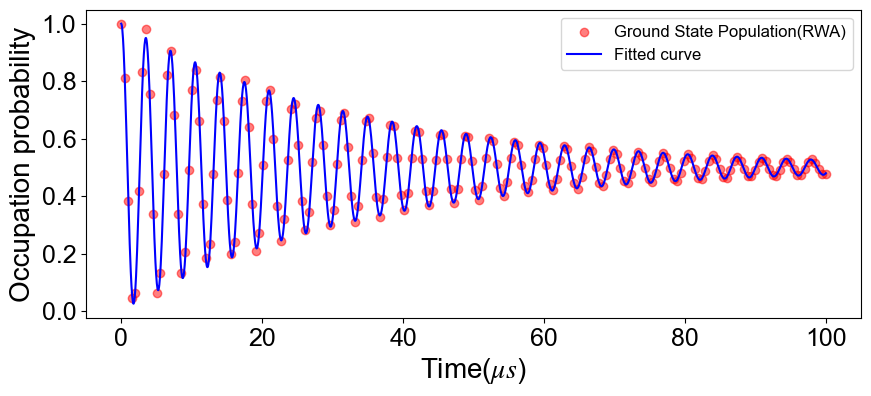

In [24]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(t_sample, output_use_rwa.expect[1], label="Ground State Population(RWA)",c="red",alpha=0.5)
def Fock_Population(param,t):                        # 定义拟合函数形式
    n,kappa = param
    population = 1/2*(1+np.cos(2*init_rabi_amp*np.sqrt(n+1)*eta*t)*np.exp(-kappa*t*(n+1)**0.7))
#     population = np.cos(init_rabi_amp*np.sqrt(n+1)*eta*t)**2*np.exp(-kappa*t*(n+1)**0.7)
    return population
def error (param,x,y):                   # 拟合残差
    return np.abs(Fock_Population(param,x)-y)
p0 = (nbar_fock,gamma)
param =leastsq(error,p0, args=(t_sample,output_use_rwa.expect[1]))
y_fitted = Fock_Population(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1,fontsize=12)
ax.set_xlabel(r"Time($\mu s$)",fontsize=20)
ax.set_ylabel("Occupation probability",fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
print("Fit Fock State Number=",int(param[0][0]))
print("Fit Param=",param[0])

# Thermal State

\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \sum_{n=0}^{\infty}P_n\cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
热态下有:
where $P_n= (\frac{\bar{n}}{\bar{n}+1})^n(\frac{1}{\bar{n}+1})$


\begin{equation}
    \rho = \frac{\exp(-H/k_BT)}{\text{Tr}(\exp(-H/k_BT))}
\end{equation}


此时哈密顿量可以利用产生湮灭算符表示:

\begin{equation}
    H = \hbar w(a^\dagger a+\frac{1}{2})
\end{equation}

而$\rho = \sum_n p _n |{n}\rangle\langle{n}|$

故

\begin{equation}
    p_n = \langle{n}|\rho|{n}\rangle = \frac{\langle{n}|\exp(-H/k_BT)|{n}\rangle}{\text{Tr}(\exp(-H/k_BT))}
\end{equation}

其中

\begin{equation}
    \text{Tr} (\exp(-H/k_BT)) =  \sum_{n}\langle{n}|\exp(-H/k_BT)|{n}\rangle = \sum_n(\exp(-\hbar wn/k_BT))\exp(-\frac{1}{2k_BT})
\end{equation}


等比数量求和得到:

\begin{equation}
    \sum_n(\exp(-\hbar wn/k_BT))\exp(-\frac{1}{2k_BT}) = \exp(-\frac{1}{2k_BT}) \frac{1}{1-\exp(-\hbar w /k_BT)}
\end{equation}

而

\begin{equation}
    \langle{n}|\exp(-H/k_BT)|{n}\rangle = \exp(-n\hbar w/k_BT)\exp(-\frac{1}{2k_BT})
\end{equation}


故:

\begin{equation}
    p_n =(1-\exp(-\hbar w /k_BT))\exp(-n\hbar w/k_BT)
\end{equation}

故:

\begin{equation}
    \rho = \sum_n p _n |{n}\rangle\langle{n}|=(1-\exp(-\hbar w /k_BT)) \sum_n \exp(-n\hbar w/k_BT) |{n}\rangle\langle{n}|
\end{equation}


故对于平均声子数的均值为:
\begin{equation}
    \langle n \rangle = \text{Tr}(\hat{N}\rho) = \text{Tr}(\hat{a}^\dagger \hat{a}\rho)
\end{equation}

求迹:

\begin{equation}
    \sum_k\langle{k}|\hat{a}^\dagger \hat{a}\rho|{k}\rangle =(1-\exp(-\hbar w /k_BT))\sum_k\langle{n}|\sum_n n\exp(-n\hbar w/k_BT) |{n}\rangle\langle{n}|{k}\rangle
\end{equation}

故上式为:

\begin{equation}
    (1-\exp(-\hbar w /k_BT))\sum_k k\exp(-k\hbar w/k_B T)
\end{equation}

后面一项利用错位相减法可以得到:

\begin{equation}
    \sum_k k\exp(-k\hbar w/k_B T) = \exp(-\hbar w/k_BT)/(1-\exp(-\hbar w/k_BT))^2
\end{equation}

故:

\begin{equation}
    \langle n \rangle =\exp(-\hbar w/k_BT)/(1-\exp(-\hbar w/k_BT)) = (\exp(\hbar w/k_BT)-1)^{-1}
\end{equation}


回代到密度矩阵中:

\begin{equation}
    \rho  = \sum_{n}(\frac{\langle n \rangle^n}{(\langle n \rangle+1)^{n+1}})|{n}\rangle\langle{n}|
\end{equation}

故
\begin{equation}
    \rho_{n,n} = p_n = (\frac{\bar{n}}{\bar{n}+1})^n\frac{1}{\bar{n}+1}
\end{equation}

In [25]:
nth=2
rho_thermal = thermal_dm(N,nth)
dm0 = tensor(rho_thermal, ket2dm(basis(2, 0)))
tlist = np.linspace(0, 50, 2000)
t_sample = np.linspace(0, 50, 100)


c_op_list = []
# Photon creation
rate = gamma * nth
c_op_list.append(np.sqrt(rate) * a.dag())
output_use_rwa = mesolve(Hamiltonian(bsb=True), dm0, t_sample,c_ops=c_op_list,e_ops=[a.dag() * a, sm.dag() * sm])

Thermal State Average Fock Number 1.9979275595599273
Fit Param= [1.99792756 0.03619149]


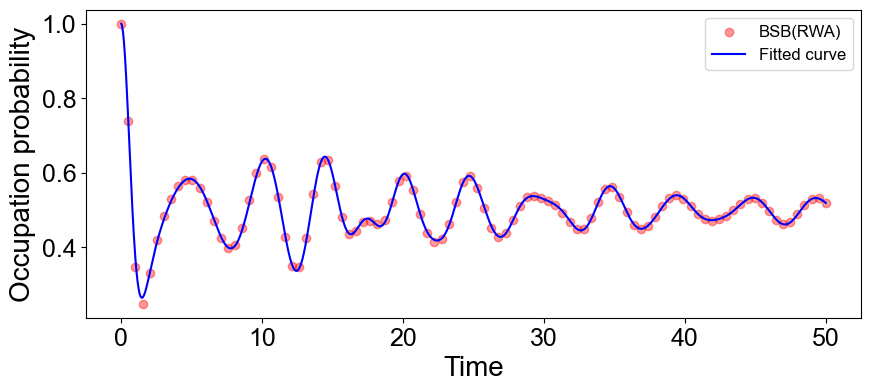

In [26]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(t_sample, output_use_rwa.expect[1], label="BSB(RWA)",c="red",alpha=0.4)
def tsp(param,t):
    nbar,kappa = param
    p = 1/2
    for i in range(N):
        pn = (nbar/(nbar+1))**(i)/(nbar+1)
        p+= 1/2*pn*np.cos(2*init_rabi_amp*np.sqrt(i+1)*eta*t)*np.exp(-kappa*t*(i+1)**0.7)
    return p
def tsp_error (param,x,y):                   # 拟合残差
    return np.abs(tsp(param,x)-y)
p0 = (nth,gamma)
param =leastsq(tsp_error, p0, args=(t_sample,output_use_rwa.expect[1]))
y_fitted = tsp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1,fontsize=12)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Occupation probability",fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
# ax.set_xlim(0,50)
print("Thermal State Average Fock Number",float(param[0][0]))
print("Fit Param=",param[0])

# Coherent state
\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \sum_{n=0}^{\infty}P_n\cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
where $P_n=(\bar{n}^ne^{-\bar{n}})/n!$

In [27]:

nbar = 3.1
coherent_state = coherent(N, np.sqrt(nbar))
psi0 = tensor(coherent_state, basis(2, 0))

tlist = np.linspace(0, 50, 500)
tsamples = np.linspace(0,50,200)

c_op_list = []

# Photon creation
rate = gamma * nbar
c_op_list.append(np.sqrt(rate) * a.dag())

output_use_rwa = mesolve(Hamiltonian(bsb=True), psi0, tsamples,c_ops=c_op_list,e_ops=[a.dag() * a, sm.dag() * sm])

Coherent State Average Fock Number 3.3434127401105767
Fit Param= [3.34341274 0.048452  ]


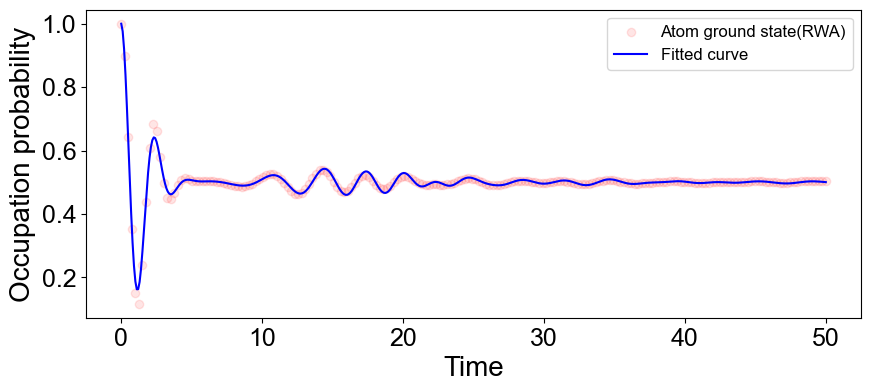

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(tsamples, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.1)
def csp(param,t):                        # 定义拟合函数形式
    nbar,kappa = param
    p = 1/2
    for i in range(N):
        pn = (nbar**i)*np.exp(-nbar)/np.math.factorial(i)
        p += pn*1/2*np.cos(2*init_rabi_amp*np.sqrt(i+1)*eta*t)*np.exp(-kappa*t*(i+1)**0.7)
    return p
def csp_error (param,x,y):                   # 拟合残差
    return np.abs(csp(param,x)-y)
p0 = (nbar,gamma)
param =leastsq(csp_error, p0, args=(tsamples,output_use_rwa.expect[1]))
y_fitted = csp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1,fontsize=12)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Occupation probability",fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
print("Coherent State Average Fock Number",float(param[0][0]))
print("Fit Param=",param[0])

# Squeezed State

\begin{equation}
S(\xi) = \exp(\frac{1}{2}(\xi (\hat{a}^\dagger)^2-\xi^*a^2));\xi=re^{i\theta}
\end{equation}
And
\begin{equation}
S(\xi)|{0} \rangle= \exp(-\frac{1}{4}|\xi|^2)\sum_n\frac{\xi^n}{n!2^n}\sqrt{(2n)!}|2n\rangle
\end{equation}
And express in r:
\begin{equation}
|0,r\rangle = \frac{1}{\sqrt{cosh(r)}}\sum_n\frac{\sqrt{(2n)!}}{2^nn!}tanh (r^n)|2n\rangle
\end{equation}
The population distribution for a vacuum squeezed state is relatively flat and is restricted to the even states,
\begin{equation}
P_{2n} = N(2n)!(tanh(r^{2n}))/(2^nn!)^2,\text{ with }\beta= \exp(2r)
\end{equation}
https://physics.stackexchange.com/questions/425290/derive-explicit-expression-of-squeezed-vacuum-state-in-the-fock-basis

In [71]:
r = 1.8444
beta = np.exp(2*r)
squeezed_state  = squeeze(N,beta)*basis(N,0)
psi0 = tensor(fock(N,20), basis(2, 0))
print(beta)
tlist = np.linspace(0, 20, 500)
tsamples = np.linspace(0, 20, 500)
#Under RWA
def SqueezedHamiltonian():
    #In lamb dicke regime(eta \ll 1)
    H0 = init_rabi_amp*eta**2/2*((a.dag())**2*sm+a**2*sp)
    return H0
output_use_rwa = mesolve(SqueezedHamiltonian(),psi0, tsamples,e_ops=[a.dag() * a, sm.dag() * sm])

39.99682196169833


Squeezed State Param 1.1959845138360958e-05
Fit Param= [-1.19598451e-05  1.90240934e+00]


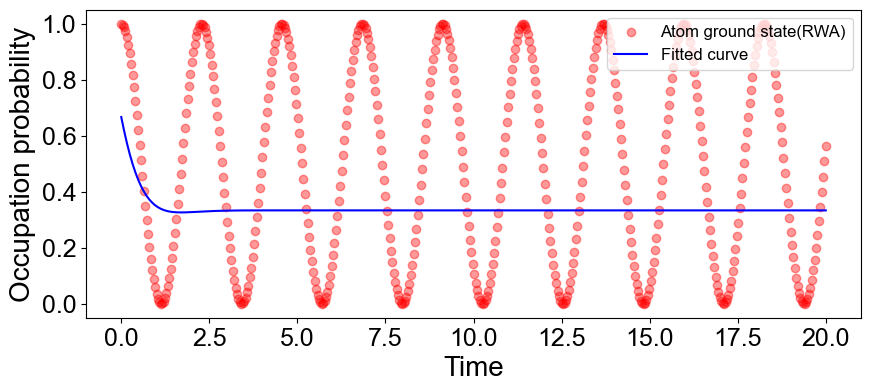

In [72]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(tsamples, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.4)
def sqp(param,t):                        # 定义拟合函数形式
    r,kappa = param
    p = 1/2
    coeff = 1/2
    for i in range(0,N,2):
        ith = i//2
        pn = float(np.math.factorial(i)*np.tanh(r)**i/(2**ith*np.math.factorial(ith))**2)
        p+= pn*1/2*np.cos(2*init_rabi_amp*np.sqrt(i+1)*eta*t)*np.exp(-kappa*t*(i+1)**0.7)
        coeff+=pn
    return p/coeff
def sqp_error (param,x,y):                   # 拟合残差
    return np.abs(sqp(param,x)-y)
p0 = (r,gamma)
param =leastsq(sqp_error, p0, args=(tsamples,np.real(output_use_rwa.expect[1])))
y_fitted = sqp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1,fontsize=12)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Occupation probability",fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
print("Squeezed State Param",np.abs(float(param[0][0])))
print("Fit Param=",param[0])